# Span Batch Analysis

## Initialization

In [2]:
import os
import re
import json
import matplotlib.pyplot as plt
import random

DATA_ROOT_DIR = "./artifacts"

In [19]:
#### FIX ME ####
l1_chain_name = "mainnet"
l2_chain_name = "op"
################

CHAIN_NAME = f"{l1_chain_name}/{l2_chain_name}"
DATA_DIR = f"{DATA_ROOT_DIR}/{CHAIN_NAME}"

In [14]:
CHANNEL_CACHE_DIR = f"{DATA_DIR}/channel_cache"
SPAN_BATCH_CACHE_V0_DIR = f"{DATA_DIR}/span_batch_cache_v0"
SPAN_BATCH_CACHE_V1_DIR = f"{DATA_DIR}/span_batch_cache_v1"
SPAN_BATCH_CACHE_V2_DIR = f"{DATA_DIR}/span_batch_cache_v2"
SPAN_BATCH_CACHE_DIRS = [SPAN_BATCH_CACHE_V0_DIR, SPAN_BATCH_CACHE_V1_DIR, SPAN_BATCH_CACHE_V2_DIR]

RESULT_V0_DIR = f"{DATA_DIR}/result_v0"
RESULT_V1_DIR = f"{DATA_DIR}/result_v1"
RESULT_V2_DIR = f"{DATA_DIR}/result_v2"
RESULT_DIRS = [RESULT_V0_DIR, RESULT_V1_DIR, RESULT_V2_DIR]

ACC_L2_START_NUM = !yq eval ".acc_l2_start_number" "span-batch-analysis/config/{l1_chain_name}/{l2_chain_name}.yaml"
ACC_L2_START_NUM = int(ACC_L2_START_NUM[0])
ACC_L2_END_NUM = !yq eval ".acc_l2_end_number" "span-batch-analysis/config/{l1_chain_name}/{l2_chain_name}.yaml"
ACC_L2_END_NUM = int(ACC_L2_END_NUM[0])


In [15]:
TARGET_DIR = RESULT_V2_DIR

Get number of channels and each channel names. Channel name must have length 32 in hexadecimal form.

In [16]:
def is_hexadecimal(s: str) -> bool:
    hex_pattern = re.compile(r'^[a-fA-F0-9]+$')
    return bool(hex_pattern.match(s))


def read_channel_ids(directory):
    channel_ids = set()
    with os.scandir(directory) as entries:
        for entry in entries:
            assert entry.is_file()
            filename = entry.name
            channel_id, ext = os.path.splitext(filename)
            assert ext == ".json" and len(channel_id) == 32 and is_hexadecimal(channel_id)
            channel_ids.add(channel_id)
    return channel_ids


def not_ready_channel_ids(channel_ids):
    not_ready = []
    for channel_id in channel_ids:
          filename = f"{CHANNEL_CACHE_DIR}/{channel_id}.json"
          with open(filename) as f:
              result = json.load(f)
              if not result["is_ready"]:
                  not_ready.append(channel_id)
    return not_ready


channel_ids = read_channel_ids(CHANNEL_CACHE_DIR)
not_ready = not_ready_channel_ids(channel_ids)

channel_ids = list(set(channel_ids) - set(not_ready))

channel_id_count = len(channel_ids)
print(f"Number of channels: {channel_id_count}")

Number of channels: 408


Sanity check of results. Number of jsons in each result directory must be equal to number of (ready) channels.

In [17]:
for directory in SPAN_BATCH_CACHE_DIRS:
    temp_channel_ids = read_channel_ids(directory) 
    assert set(temp_channel_ids) == set(channel_ids), (len(temp_channel_ids), len(channel_ids))

Relation between `UncompressedSizeReductionPercent` and `SpanBatchMetadataSizePercent`. They should be proportional.

`SpanBatchMetadataSizePercent` := `100 * SpanBatchMetadataSize / SpanBatchSize`


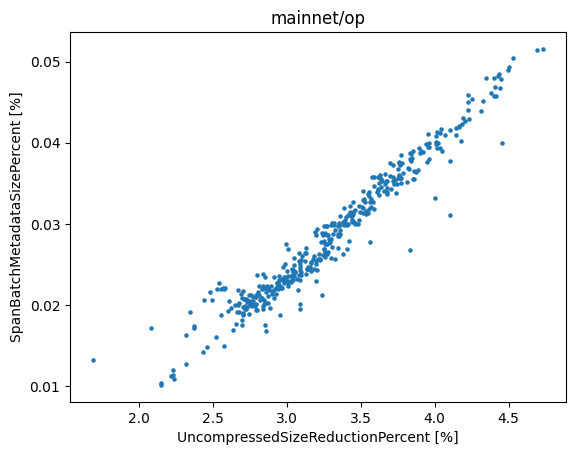

In [20]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Xs.append(uncompressed_reduction_precent)
            metadata_size = result["SpanBatchMetadataSize"]
            tx_size = result["SpanBatchTxSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("UncompressedSizeReductionPercent [%]")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Time series of `UncompressedSizeReductionPercent`. 

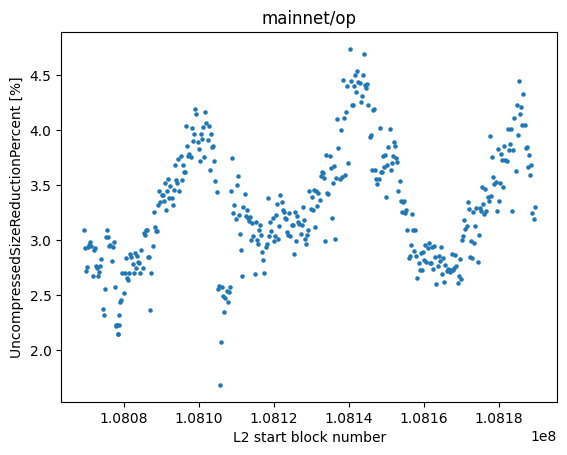

In [24]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)
            
plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 start block number")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Time series of `SpanBatchMetadataSizePercent`.

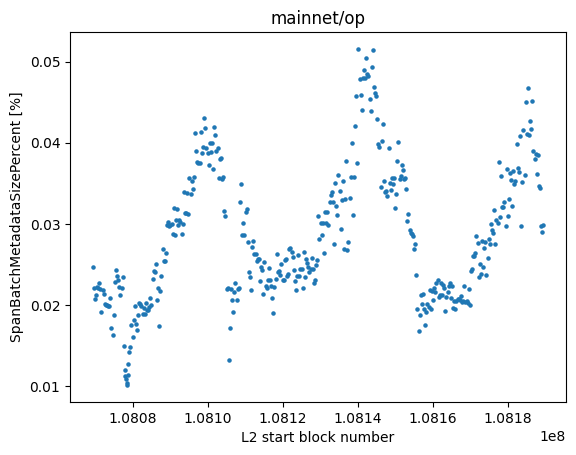

In [26]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_start_num = result["L2StartNum"]
            Xs.append(l2_start_num)
            tx_size = result["SpanBatchTxSize"]
            metadata_size = result["SpanBatchMetadataSize"]
            metadata_percent = metadata_size / (metadata_size + tx_size) * 100
            Ys.append(metadata_percent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 start block number")
plt.ylabel("SpanBatchMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Relation between `L2TxCount` and `UncompressedSizeReductionPercent`.

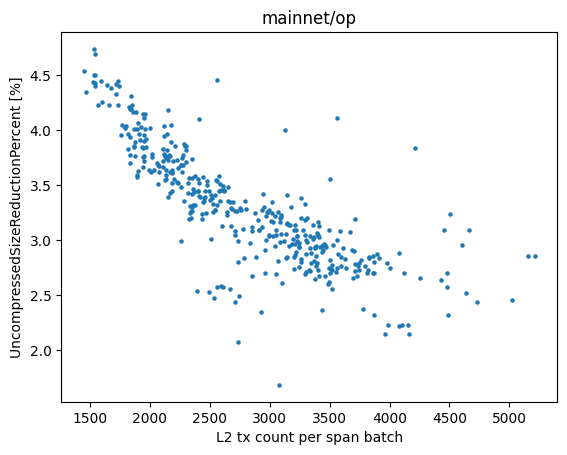

In [28]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            l2_tx_count = result["L2TxCount"]
            Xs.append(l2_tx_count)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)

plt.scatter(Xs, Ys, s=5)
plt.xlabel("L2 tx count per span batch")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Relation between `BatchV1sUncompressedSize` and `UncompressedSizeReductionPercent`.

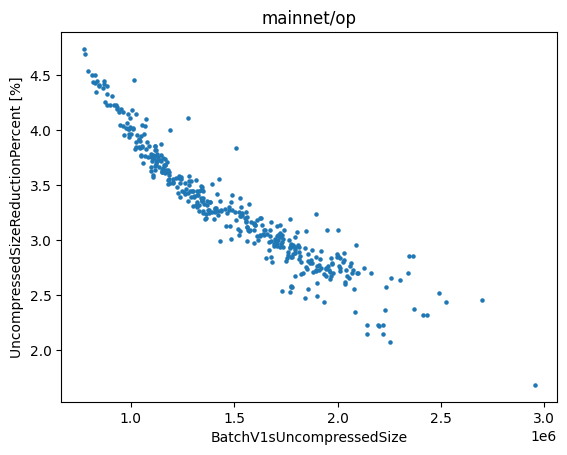

In [29]:
Xs = []
Ys = []
for channel_id in channel_ids:
      filename = f"{TARGET_DIR}/{channel_id}.json"
      with open(filename) as f:
            result = json.load(f)
            batch_v1s_uncompressed_size = result["BatchV1sUncompressedSize"]
            Xs.append(batch_v1s_uncompressed_size)
            uncompressed_reduction_precent = result["UncompressedSizeReductionPercent"]
            Ys.append(uncompressed_reduction_precent)


plt.scatter(Xs, Ys, s=5)
plt.xlabel("BatchV1sUncompressedSize")
plt.ylabel("UncompressedSizeReductionPercent [%]")
plt.title(CHAIN_NAME)
plt.show()

Sample single channel and observe span batch results.

In [57]:
def sample():
    channel_id = random.choice(list(channel_ids))
    results = []
    for dir in RESULT_DIRS:
        filename = f"{dir}/{channel_id}.json"
        with open(filename) as f:
            result = json.load(f)
            results.append(result)
    return channel_id, results

channel_id, results = sample()
print(f"{channel_id = }")
for result in results:
    print(result)

channel_id = 'a0f99edac84cae2082a9e3519fa50479'
{'FrameCount': 6, 'BatchV1sCompressedSize': 660735, 'BatchV1sUncompressedSize': 1846651, 'BatchV1sCompressionRatio': 0.3578017719644914, 'SpanBatchCompressedSize': 624852, 'SpanBatchUncompressedSize': 1807609, 'SpanBatchCompressionRatio': 0.34567873915210645, 'BatchV1sMetadataSize': 32447, 'BatchV1sTxSize': 1814204, 'SpanBatchMetadataSize': 380, 'SpanBatchTxSize': 1807229, 'SpanBatchPrefixSize': 48, 'SpanBatchPayloadSize': 1807561, 'CompressedReductionPercent': 5.430770278553432, 'UncompressedSizeReductionPercent': 2.114205662033597, 'L2TxCount': 3242, 'L1StartNum': 17890165, 'L1EndNum': 17890214, 'L1BlockCount': 50, 'L2StartNum': 108070175, 'L2EndNum': 108070467, 'L2BlockCount': 293}
{'FrameCount': 6, 'BatchV1sCompressedSize': 660735, 'BatchV1sUncompressedSize': 1846651, 'BatchV1sCompressionRatio': 0.3578017719644914, 'SpanBatchCompressedSize': 644212, 'SpanBatchUncompressedSize': 1823009, 'SpanBatchCompressionRatio': 0.353378398022171, 

Plots before compression.

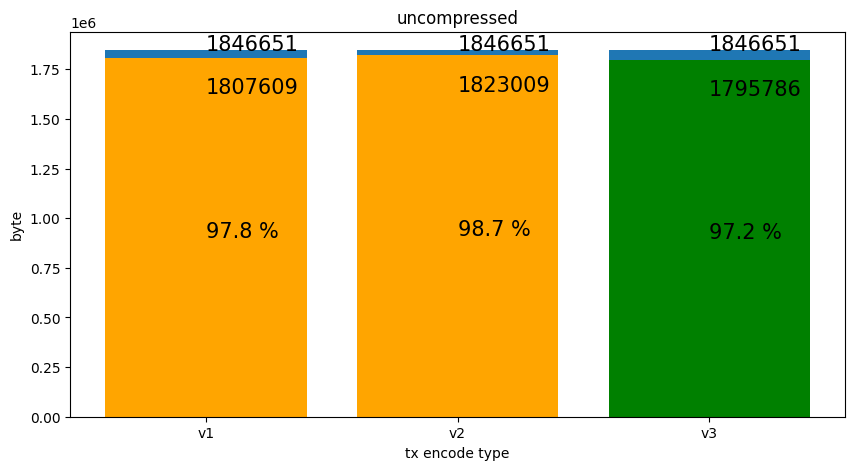

In [58]:
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sUncompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchUncompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["UncompressedSizeReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value * 0.9, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("uncompressed")
plt.show()

Plots after compression.

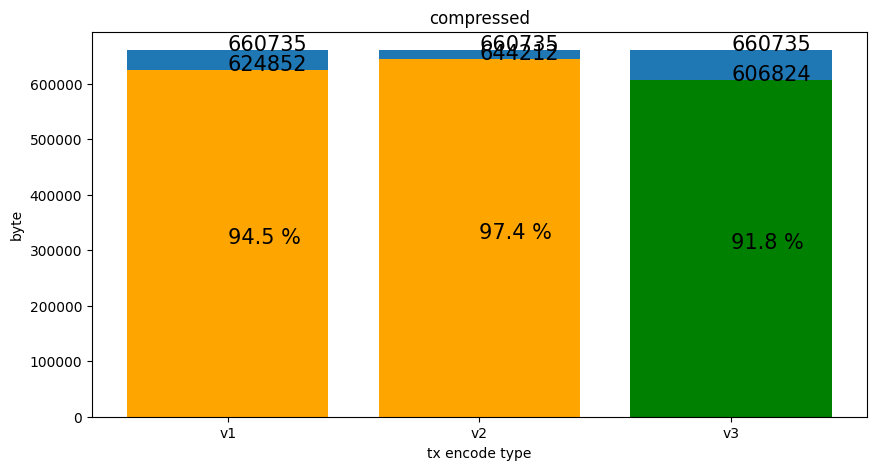

In [59]:
index = [f"v{i + 1}" for i in range(3)]
data_batchV0 = {
    f"v{i + 1}": results[i]["BatchV1sCompressedSize"] for i in range(3)
}
data_spanbatch = {
    f"v{i + 1}": results[i]["SpanBatchCompressedSize"] for i in range(3)
}
data_reduction_percent = {
    f"v{i + 1}": results[i]["CompressedReductionPercent"] for i in range(3)
}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.bar(x=index, height=data_batchV0.values(), align="center")
for key, value in data_batchV0.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))

# indicate best tx encoding as green
colors = ["orange" for _ in index]
min_idx = list(data_reduction_percent.values()).index(max(data_reduction_percent.values()))
colors[min_idx] = "green"

ax.bar(x=index, height=data_spanbatch.values(), align="center", color=colors)
for key, value in data_spanbatch.items():
    plt.text(x=key, y=value+1, s=f"{value}", fontdict=dict(fontsize=15))
    percentage = f"{str(100 - data_reduction_percent[key])[:4]} %"
    plt.text(x=key, y=value // 2, s=percentage, fontdict=dict(fontsize=15))

plt.xlabel("tx encode type")
plt.ylabel("byte")
plt.title("compressed")
plt.show()

# Span Batch Analysis - L2 Block Accumulation

Relation between `L2BlockCount` and (`UncompressedSizeReductionPercent`, `BatchV1sMetadataSizePercent`).

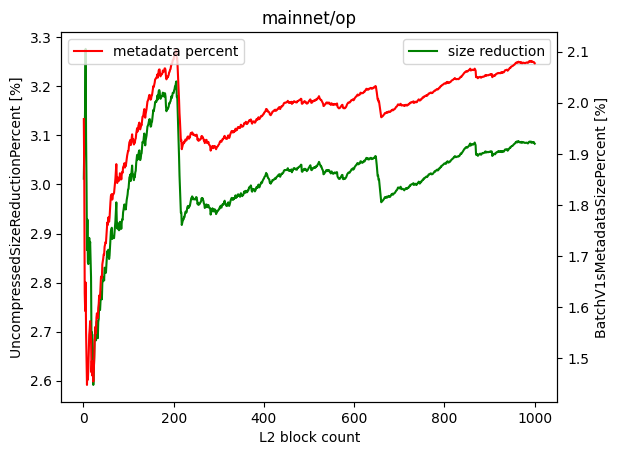

In [73]:
FILENAME = f"{DATA_DIR}/merge_result/{ACC_L2_START_NUM}_{ACC_L2_END_NUM}.json"
CLAMP = 0

Xs, Ys, Zs = [], [], []
with open(FILENAME) as f:
    result = json.load(f)["Result"]
    for i in range(CLAMP, ACC_L2_END_NUM - ACC_L2_START_NUM):
        # check L2EndNum is sane
        assert result[i]["L2EndNum"] == ACC_L2_START_NUM + i
        
        l2_block_count = result[i]["L2BlockCount"]
        Xs.append(l2_block_count)
        uncompressed_reduction_precent = result[i]["UncompressedSizeReductionPercent"]
        Ys.append(uncompressed_reduction_precent)
        tx_size = result[i]["BatchV1sTxSize"]
        metadata_size = result[i]["BatchV1sMetadataSize"]
        metadata_percent = metadata_size / (metadata_size + tx_size) * 100
        Zs.append(metadata_percent)
        

fig, ax1 = plt.subplots()
ax1.plot(Xs, Ys, label="size reduction", c="green")
ax2 = ax1.twinx()
ax2.plot(Xs, Zs, label="metadata percent", c="red")
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_xlabel("L2 block count")
ax1.set_ylabel("UncompressedSizeReductionPercent [%]")
ax2.set_ylabel("BatchV1sMetadataSizePercent [%]")
plt.title(CHAIN_NAME)
plt.show()